In [2]:
import warnings
warnings.filterwarnings ( "ignore" )
import os
from datetime import datetime , timedelta , time , date
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import xarray as xr
import global_settings as gs
import numpy as np
import preprocessing as prep
def angstrom(tau_1,tau_2, lambda_1,lambda_2):
	"""
	calculates angstrom exponent
	:param tau_1: AOD Aerosol optical depth at wavelength lambda_1
	:param tau_2: AOD Aerosol optical depth at wavelength lambda_2
	:param lambda_1: wavelength lambda_1 , lambda_1<lambda_2 (e.g. 355 nm)
	:param lambda_2: wavelength lambda_2 , lambda_1<lambda_2 (e.g. 532 nm)
	:return: angstrom exponent A_1,2
	"""
	return -np.log(tau_1/tau_2)/np.log(lambda_1/lambda_2)

## Load AERONET file of September 2017

##### This notebook shows how to calculate Angstrom exponent based on AERONET measurements taken from the sunphotometere on EE building.

##### Mean values per day will be using as typical values for aerosols creation

In [3]:
station = gs.Station('haifa')
month = 9
year = 2017
monthdays = (date(year,month+1,1)-date(year,month,1)).days
start_day = datetime(year,month,1,0,0)
end_day = datetime(year,month,monthdays,0,0)
wavelengths = [355,532,1064]

base_name = f"{start_day.strftime('%Y%m%d')}_{end_day.strftime('%Y%m%d')}_{station.aeronet_name}"
file_name = os.path.join(station.aeronet_folder,base_name,base_name+'.lev20')
aeronet_data = pd.read_csv ( file_name , skiprows = 6).dropna ( )

#### Parse data and rename columns for easier extrapolation of AOD values

In [4]:
df_dt = pd.to_datetime(aeronet_data['Date(dd:mm:yyyy)']+aeronet_data['Time(hh:mm:ss)'], format = "%d:%m:%Y%H:%M:%S")
columns = ['AOD_1640nm', 'AOD_1020nm','AOD_675nm','AOD_500nm','AOD_380nm','AOD_340nm']
df_AOD_ANGSTROM = aeronet_data[columns]
df_AOD_ANGSTROM.index = df_dt
for col in sorted(columns):
	col_new = int(col.split('_')[1].replace('nm',''))
	df_AOD_ANGSTROM.rename(columns = {col:col_new},inplace = True)

cols =  df_AOD_ANGSTROM.columns.values.tolist()
cols.extend(wavelengths)
df_AOD_ANGSTROM = df_AOD_ANGSTROM.reindex(cols, axis = 'columns').sort_index(axis = 1)

#### Calculate AOD for missing wavelengths as $355,532,1064$ by interpolation values from the nearest existing measured wavelengths.

In [5]:
cols = df_AOD_ANGSTROM.columns.values.tolist()
# %%
for wavelength in wavelengths:
	col_ind = df_AOD_ANGSTROM.columns.get_loc(wavelength)
	ratio = (cols[col_ind+1] - cols[col_ind])/(cols[col_ind+1] - cols[col_ind-1])
	df_AOD_ANGSTROM[wavelength] = df_AOD_ANGSTROM.iloc[:,col_ind-1]*ratio+ (1-ratio)*df_AOD_ANGSTROM.iloc[:,col_ind+1]

In [6]:
#df_AOD_ANGSTROM

Create dataset of AOD per wavelength

In [7]:
ds_chans =[]

for wavelength in wavelengths:
	field_name = f"AOD_{wavelength}"
	aeronet_ds_chan = xr.Dataset (
	    data_vars = {'aod' : (('Time') , df_AOD_ANGSTROM[wavelength]) ,
                     'lambda_nm' : ('Wavelength' , [ wavelength ])
                     } ,
        coords = {'Time' : df_AOD_ANGSTROM.index.tolist() ,
                  'Wavelength' : [ wavelength ]
                  })
	ds_chans.append(aeronet_ds_chan)
ds_aod = xr.concat ( ds_chans , dim = 'Wavelength' )
ds_aod.aod.attrs['long_name']= r'$\tau$'
ds_aod.attrs = {'info': 'Aerosol Optical Depth - generated from AERONET - level 2.0',
                'location': station.name, 'source_file': file_name,
                'start_time': start_day.strftime ( "%Y-%d-%m" ), 'end_time': end_day.strftime ( "%Y-%d-%m" )}
ds_aod = ds_aod.aod.where(ds_aod>=0,drop=True)

Calculate Angstrom Exponent
## $A = -\frac {\ln(\tau_1/\tau_2)}{\ln(\lambda_1/\lambda_2)},\; \lambda_1\leq\lambda_2$

In [8]:
couples = [(355,532),(355,1064),(532,1064)]
angstrom_daily = []
for lambda_1,lambda_2 in couples:
	angstrom_couple = xr.apply_ufunc(lambda x,y:angstrom(ds_aod.sel(Wavelength=x),
	                                                     ds_aod.sel(Wavelength=y),x,y),lambda_1,lambda_2,keep_attrs = True)
	angstrom_ds_chan = xr.Dataset (
	    data_vars = {'angstrom' : (('Time') , angstrom_couple.aod) ,
                     'lambda_nm' : ('Wavelengths' , [ f"{lambda_1}-{lambda_2}" ])
                     } ,
        coords = {'Time' : df_AOD_ANGSTROM.index.tolist() ,
                  'Wavelengths' :[ f"{lambda_1}-{lambda_2}" ]
                  })


	angstrom_daily.append(angstrom_ds_chan)
ds_ang = xr.concat ( angstrom_daily,dim = 'Wavelengths')
ds_ang.angstrom.attrs['long_name']= r'$\AA$'
ds_ang.attrs = {'info': 'Angstrom Exponent - generated from AERONET AOD',
                'location': station.name, 'source_file': file_name,
                'start_time': start_day.strftime ( "%Y-%d-%m" ), 'end_time': end_day.strftime ( "%Y-%d-%m" )}

Show AOD and Angstrom Exponent for a period

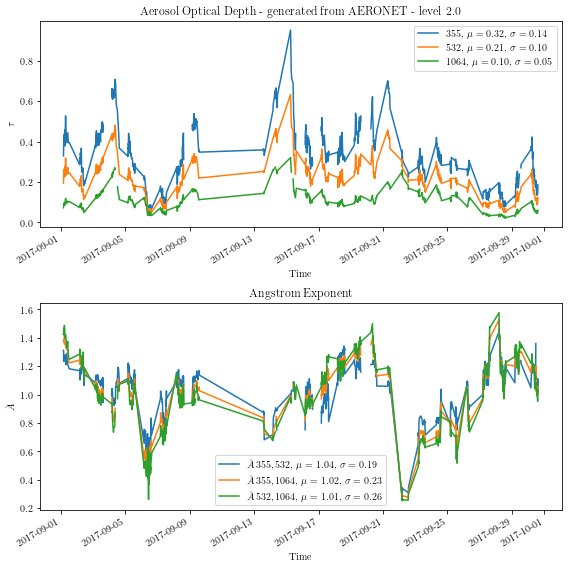

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
t_slice =slice(start_day,start_day+timedelta(days =30)-timedelta(seconds = 30))
ax = axes.ravel()
for wavelength in wavelengths:
	aod_mean = ds_aod.aod.sel(Wavelength = wavelength,Time=t_slice).mean().item()
	aod_std =  ds_aod.aod.sel(Wavelength = wavelength,Time=t_slice).std().item()
	textstr = ' '.join((
	r'$\mu=%.2f$, ' % (aod_mean, ),
	r'$\sigma=%.2f$' % (aod_std, )))
	ds_aod.aod.sel(Wavelength = wavelength,Time=t_slice).plot(label = fr"{wavelength}, "+textstr,ax=ax[0])
ax[0].set_title(ds_aod.attrs['info'])
ax[0].legend()
ax[0].set_ylabel( r'$\tau$')

couples = [(355,532),(355,1064),(532,1064)]
angstrom_daily = []
for lambda_1,lambda_2 in couples:
	angstrom_mean = ds_ang.angstrom.sel(Wavelengths = f"{lambda_1}-{lambda_2}" ,Time=t_slice).mean().item()
	angstrom_std = ds_ang.angstrom.sel(Wavelengths = f"{lambda_1}-{lambda_2}" ,Time=t_slice).std().item()
	textstr = ' '.join((
	r'$\mu=%.2f$, ' % (angstrom_mean, ),
	r'$\sigma=%.2f$' % (angstrom_std, )))
	ds_ang.angstrom.sel(Wavelengths = f"{lambda_1}-{lambda_2}" ,Time=t_slice).\
		plot(x='Time',label =fr"$ \AA \, {lambda_1},{lambda_2}$, "+textstr,ax = ax[1])
ax[1].legend()
ax[1].set_title('Angstrom Exponent')
plt.tight_layout()
plt.show()

Angstrom Exponent distribution of a month

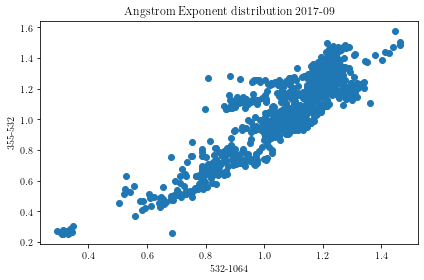

In [31]:
couple_0 = f"{355}-{532}"
couple_1 = f"{532}-{1064}"
angstrom_daily = []

x = ds_ang.angstrom.sel(Time=t_slice,Wavelengths = couple_0).values
y = ds_ang.angstrom.sel(Time=t_slice,Wavelengths = couple_1).values

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(x=x,y=y)
ax.set_ylabel(couple_0)
ax.set_xlabel(couple_1)
ax.set_title(f"Angstrom Exponent distribution {t_slice.start.strftime('%Y-%m')}")
plt.tight_layout()
plt.show()

In [30]:
t_slice

slice(datetime.datetime(2017, 9, 1, 0, 0), datetime.datetime(2017, 9, 30, 23, 59, 30), None)

Save AOD and  Angstrom Exponent datasets

In [9]:
folder_name = station.aeronet_folder
nc_name = f"{start_day.strftime('%Y%m%d')}_{end_day.strftime('%Y%m%d')}_{station.name}_aod.nc"
prep.save_dataset ( ds_aod , folder_name , nc_name )

nc_name = f"{start_day.strftime('%Y%m%d')}_{end_day.strftime('%Y%m%d')}_{station.name}_ang.nc"
prep.save_dataset ( ds_ang , folder_name , nc_name )

'D:\\data_haifa\\AERONET\\20170901_20170930_haifa_ang.nc'

#### TODOs:
1. Add a section of AERONET dataset preparation to preprocessing.py
2. Apply this notebook on any month measured during the year.
2. Add the calibration info to ds_day in synthisize_lidar_measurments.ipynb

In [10]:
ds_ang

<xarray.Dataset>
Dimensions:      (Time: 944, Wavelengths: 3)
Coordinates:
  * Time         (Time) datetime64[ns] 2017-09-01T04:20:30 ... 2017-09-30T14:...
  * Wavelengths  (Wavelengths) object '355-532' '355-1064' '532-1064'
Data variables:
    angstrom     (Wavelengths, Time) float64 1.311 1.306 1.237 ... 1.019 1.038
    lambda_nm    (Wavelengths) <U8 '355-532' '355-1064' '532-1064'
Attributes:
    info:         Angstrom Exponent - generated from AERONET AOD
    location:     haifa
    source_file:  D:\data_haifa\AERONET\20170901_20170930_Technion_Haifa_IL\2...
    start_time:   2017-01-09
    end_time:     2017-30-09